Episode 1: Average Reward (last 100 episodes): 5.00
Episode 101: Average Reward (last 100 episodes): 29.20
Episode 201: Average Reward (last 100 episodes): 21.68
Episode 301: Average Reward (last 100 episodes): 19.64
Episode 401: Average Reward (last 100 episodes): 21.55
Episode 501: Average Reward (last 100 episodes): 24.49
Episode 601: Average Reward (last 100 episodes): 25.74
Episode 701: Average Reward (last 100 episodes): 25.41
Episode 801: Average Reward (last 100 episodes): 24.18
Episode 901: Average Reward (last 100 episodes): 20.37
Episode 1001: Average Reward (last 100 episodes): 22.46
Episode 1101: Average Reward (last 100 episodes): 23.38
Episode 1201: Average Reward (last 100 episodes): 26.61
Episode 1301: Average Reward (last 100 episodes): 27.85
Episode 1401: Average Reward (last 100 episodes): 23.52
Episode 1501: Average Reward (last 100 episodes): 18.49
Episode 1601: Average Reward (last 100 episodes): 26.90
Episode 1701: Average Reward (last 100 episodes): 24.64
Episo

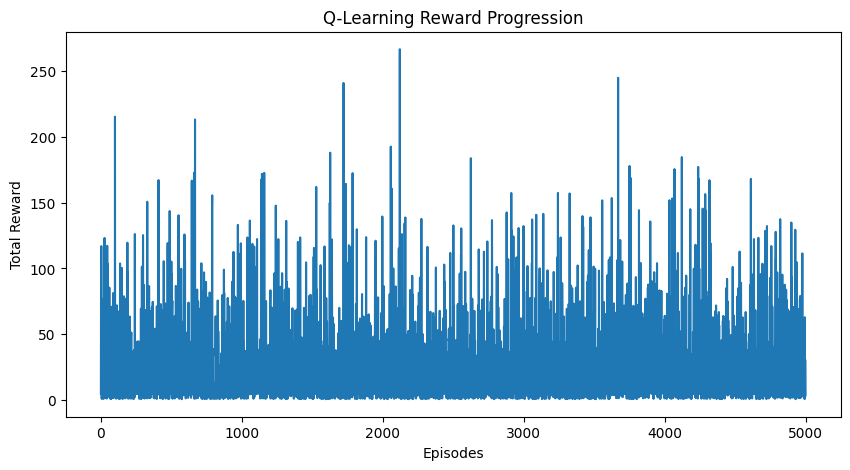

✅ Q-Learning Contract Negotiation Model Trained & Performance Tracked!


In [ ]:
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

# Load Player Data
player_data = pd.read_csv("filtered_playerratingssalaries.csv")
player_data = player_data.dropna(subset=["GROSS P/Y (EUR)", "Rating", "CLUB", "pos"])

# Club reputation mapping (higher value = bigger club)
club_reputation = {
    "Barcelona": 10, "Real Madrid": 10, "Manchester City": 9, "Bayern Munich": 9,
    "Liverpool": 8, "Chelsea": 8, "Juventus": 8, "Paris Saint-Germain": 8,
    "Marseille": 5, "Everton": 6, "West Ham": 6, "Lyon": 6,
}

# Define Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define Contract Negotiation Environment
class ContractNegotiationEnv:
    def __init__(self, player_data):
        self.player_data = player_data
        self.player = None
        self.state = None
        self.done = False
        self.club_factor = 5  # Default club reputation
        self.action_space = [0, 1, 2, 3]  # Actions: Accept, Negotiate, Change Length, Reject

    def reset(self, player_name):
        """Reset environment with a specific player, using latest season's data"""
        player_seasons = self.player_data[self.player_data["PLAYER"] == player_name]
        self.player = player_seasons.iloc[-1]

        # Get next season's rating prediction
        next_season = self.player["Season"] + 1
        future_data = player_seasons[player_seasons["Season"] == next_season]
        predicted_rating = future_data["Rating"].values[0] if not future_data.empty else self.player["Rating"]

        self.club_factor = club_reputation.get(self.player["CLUB"], 5)

        # Encode Position (Forwards tend to have higher salaries)
        position_mapping = {"Forward": 3, "Midfielder": 2, "Defender": 1, "Goalkeeper": 0}
        player_position = position_mapping.get(self.player["pos"], 1)

        self.state = np.array([
            self.player["age"],
            self.player["Rating"],
            predicted_rating,
            self.player["GROSS P/Y (EUR)"],
            0,  # Club Proposed Wage
            2,  # Default contract length
            player_position
        ], dtype=float)

        self.done = False
        return self.state

    def step(self, action, proposed_wage, contract_length):
        """Take an action in contract negotiation"""
        age, current_rating, predicted_rating, current_wage, _, _, position = self.state
        self.state[4] = proposed_wage  # Update club's proposed wage
        self.state[5] = contract_length  # Update contract length

        base_reward = (current_rating - 5) * 1.2  # Reduce sensitivity
        age_penalty = max(0, (age - 30) * -0.5)
        club_bonus = (self.club_factor - 5) * 0.5
        position_bonus = position * 2  # Forwards get higher contracts

        if action == 0:  # Accept Contract
            reward = -3 + base_reward + age_penalty + club_bonus + position_bonus
            self.done = True

        elif action == 1:  # Negotiate Higher Wage
            if proposed_wage > current_wage * 1.2:
                reward = -1 - club_bonus
            else:
                reward = 27 + base_reward + age_penalty

        elif action == 2:  # Change Contract Length
            if contract_length < 2:
                reward = -2
            elif contract_length > 5:
                reward = -2
            else:
                reward = 8 + club_bonus

        else:  # Reject & Demand Transfer
            reward = 10 if current_rating > 7.0 else 5
            self.done = True

        return np.array(self.state, dtype=float), reward, self.done

class Agent:
    def __init__(self, state_dim, action_dim, lr=0.0005, gamma=0.95, epsilon=1.0, epsilon_decay=0.9999, epsilon_min=0.05):
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=10000)  # Increased buffer for stability

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice([0, 1, 2, 3])
        state = torch.tensor(state, dtype=torch.float32)
        return torch.argmax(self.model(state)).item()


    def train(self, batch_size=128):
        if len(self.memory) < batch_size:
            return

        # 🔹 Extract only valid experience tuples (ensuring all have 5 elements)
        valid_experiences = [exp for exp in self.memory if len(exp) == 5]

        if len(valid_experiences) < batch_size:
            return  # Ensure enough experiences exist before training

        # 🔹 Extract absolute rewards for prioritization
        priorities = np.array([exp[4] for exp in valid_experiences])

        # 🔹 Normalize probabilities to avoid division errors
        if np.sum(priorities) == 0:
            probabilities = np.ones(len(valid_experiences)) / len(valid_experiences)
        else:
            probabilities = priorities / np.sum(priorities)

        # 🔹 Ensure correct number of indices
        indices = np.random.choice(len(valid_experiences), batch_size, p=probabilities)

        # 🔹 Select valid experiences
        minibatch = [valid_experiences[i] for i in indices]

        for state, action, reward, next_state, _ in minibatch:
            target = reward + self.gamma * torch.max(self.model(torch.tensor(next_state, dtype=torch.float32)))
            output = self.model(torch.tensor(state, dtype=torch.float32))[action]
            loss = (output - target) ** 2
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()



# Train Model with Reward Tracking
env = ContractNegotiationEnv(player_data)
agent = Agent(state_dim=7, action_dim=4)  # Adjusted to match state dimensions

reward_history = []

for episode in range(5000):
    state = env.reset(random.choice(player_data["PLAYER"].unique()))
    done = False
    total_reward = 0  # Track total episode reward

    while not done:
        action = agent.select_action(state)
        proposed_wage = state[3] * (1 + random.uniform(-0.2, 0.2))
        contract_length = random.randint(2, 5)
        next_state, reward, done = env.step(action, proposed_wage, contract_length)
        agent.memory.append((state, action, reward, next_state))
        agent.train()
        state = next_state
        total_reward += reward  # Accumulate reward

    reward_history.append(total_reward)

    # Print average reward every 100 episodes
    if episode % 100 == 0:
        avg_reward = np.mean(reward_history[-100:])
        print(f"Episode {episode + 1}: Average Reward (last 100 episodes): {avg_reward:.2f}")

# Plot Reward Progression
plt.figure(figsize=(10,5))
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Q-Learning Reward Progression")
plt.show()

print("✅ Q-Learning Contract Negotiation Model Trained & Performance Tracked!")


In [ ]:
# Test Contract Negotiation for a Specific Player
test_player = "Robert Lewandowski"  # Change to any player from the dataset

state = env.reset(test_player)  # Initialize environment
done = False
total_reward = 0

print(f"\n🔹 Negotiating contract for {test_player}...")

while not done:
    action = agent.select_action(state)
    proposed_wage = state[3] * (1 + random.uniform(-0.2, 0.2))  # Random wage proposal
    contract_length = random.randint(2, 5)  # Random contract length proposal
    next_state, reward, done = env.step(action, proposed_wage, contract_length)

    print(f"➡️ Action Taken: {action} | Proposed Wage: {proposed_wage:.2f} | Contract Length: {contract_length} | Reward: {reward:.2f}")

    state = next_state
    total_reward += reward

print(f"\n✅ Final Reward for {test_player}: {total_reward:.2f}")



🔹 Negotiating contract for Robert Lewandowski...
➡️ Action Taken: 2 | Proposed Wage: 25601303.39 | Contract Length: 5 | Reward: 10.50
➡️ Action Taken: 2 | Proposed Wage: 23063410.00 | Contract Length: 2 | Reward: 10.50
➡️ Action Taken: 1 | Proposed Wage: 24730781.30 | Contract Length: 2 | Reward: 29.68
➡️ Action Taken: 3 | Proposed Wage: 23314682.34 | Contract Length: 5 | Reward: 10.00

✅ Final Reward for Robert Lewandowski: 60.68
